<center><img src="img/aism_logo.png" alt="Logo AI Saturdays Madrid" title="Logo AI Saturdays Madrid" width="150"/></center>

# Pokémons legendarios - Clasificación

Para practicar lo que hemos aprendido hasta ahora sobre EDA y modelos de clasificación, vamos a intentar encontrar un modelo de aprendizaje supervisado que nos permita clasificar los Pokémon en legendarios y no legendarios.

Para ello, vamos a usar un conjunto de datos que contiene información sobre los 801 Pokémon de las siete primeras generaciones. La información contenida en este conjunto de datos incluye estadísticas básicas, rendimiento frente a otros tipos, altura, peso, clase a la que pertenecen, puntos de experiencia, habilidades, etc.

La información para crear este conjunto de datos, el cual puede descargarse en Kaggle de [The Complete Pokemon Dataset](https://www.kaggle.com/rounakbanik/pokemon?select=pokemon.csv), se extrajo de http://serebii.net/ mediante _web scraping_.

Este conjunto de datos contiene 41 columnas, siendo su interpretación la siguiente:
* `name` - El nombre en inglés del Pokémon.
* `japanese_name` - El nombre japonés original del Pokémon
* `pokedex_number` - El número de entrada del Pokémon en el Pokédex Nacional
* `percent_male` - El porcentaje de la especie que son machos. En blanco si el Pokémon no tiene género.
* `type1` - El tipo primario del Pokémon
* `type2` - El tipo secundario del Pokémon
* `classification` - La clasificación de los Pokémon como se describe en el Pokédex Sol y Luna
* `height_m` - Altura del Pokémon en metros
* `weight_kg` - Peso del Pokémon en kilogramos
* `capture_rate` - Tasa de captura del Pokémon
* `baseeggsteps` - El número de pasos necesarios para eclosionar un huevo del Pokémon
* `abilities` - Una lista ordenada de habilidades que el Pokémon puede tener
* `experience_growth` - La experiencia de crecimiento de los Pokémon
* `base_happiness` - Felicidad de base del Pokémon
* `against_?` - Dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
* `hp` - El _hit point_ de base del Pokémon. Es una estadística que determina cuánto daño puede recibir un Pokémon antes de desmayarse
* `attack` - El ataque base del Pokémon
* `defense` - La defensa base del Pokémon
* `sp_attack` - El ataque especial base del Pokémon
* `sp_defense` - La defensa especial base del Pokémon
* `speed` - La velocidad base del Pokémon
* `base_total` - Suma de `hp`, `attack`, `defense`, `sp_attack`, `sp_defense` y `speed`
* `generation` - La generación en la que se introdujo por primera vez el Pokémon
* `is_legendary` - Indica si el Pokémon es o no legendario y es la etiqueta que vamos a tratar de predecir

Pero, ¿qué es lo que hace a un Pokémon ser legendario? Consultando [The Bulbapedia Wiki](https://bulbapedia.bulbagarden.net/wiki/Legendary_Pokémon), los Pokémon legendarios

> _...son un grupo de Pokémon increíblemente raros y, a menudo, muy poderosos, que generalmente ocupan un lugar destacado en las leyendas y los mitos del mundo Pokémon... No hay criterios explícitos que definan qué hace que un Pokémon sea un Pokémon legendario. En cambio, la única forma de identificar a un Pokémon como perteneciente a este grupo es a través de declaraciones de medios oficiales, como los juegos o el anime._

Aunque por lo que parece no existen criterios explícitos sobre lo que define a un Pokémon como legendario, vamos a comprobar si usando las estadísticas de cada Pokémon podemos encontrar algún modelo de clasificación que nos permita predecir si un Pokémon es o no legendario.

## Importar librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import plot_tree, export_text
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

## Importar y explorar los datos

**Carga los datos en un DataFrame de Pandas y llámalo `data`.**

In [2]:
data = pd.read_csv('data/pokemon.csv')

**Muestra las 5 primeras filas.**

In [3]:
data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


**Muestra las 5 últimas filas.**

In [4]:
data.tail()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1
800,['Soul-Heart'],0.25,0.5,0.0,1.0,0.5,1.0,2.0,0.5,1.0,...,NaN,801,130,115,65,steel,fairy,80.5,7,1


**Imprime la información del dataset.**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

**Muestras el resumen estadístico de las variables numéricas del conjunto de datos.**

In [6]:
data.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


**Muestra el resumen estadístico de las variables de tipo `Object` del conjunto de datos. ¿Notas algo raro?**

In [7]:
data.describe(include=['O'])

,abilities,capture_rate,classfication,japanese_name,name,type1,type2
count,801,801,801,801,801,801,417
unique,482,34,588,801,801,18,18
top,['Levitate'],45,Dragon Pokémon,Fushigidaneフシギダネ,Bulbasaur,water,flying
freq,29,250,8,1,1,114,95


`capture_rate` parece que debería ser una variable numérica pero aparece en las de tipo `Object`. Más adelante analizaremos lo que ocurre con ella.

**Comprueba qué variables tienen valores ausentes y cuántos. Muestra solo las variables que tienen valores ausentes.**

In [8]:
# Calculamos el número de valores ausentes
null_series = data.isnull().sum()

# Filtramos por las variables que tienen valores ausentes
null_series[null_series > 0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

**Usa un mapa de calor para mostrar las variables que tienen valores ausentes. Investiga la librería [`missingno`](https://github.com/ResidentMario/missingno), aunque no es necesario que la uses para responder a esta cuestión.**

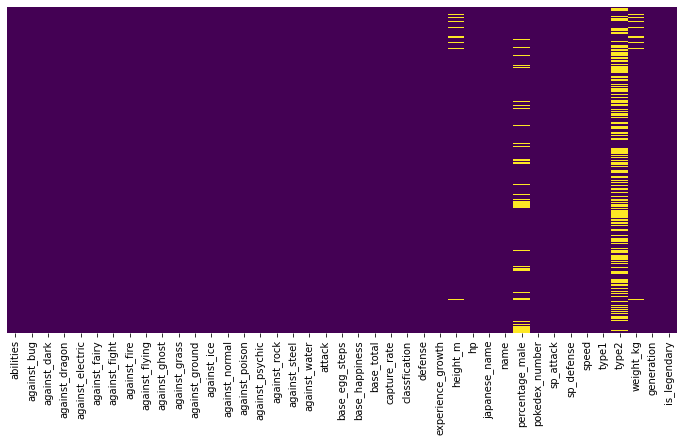

In [9]:
plt.figure(figsize=[12, 6])
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis');

**Haz un recuento de la variable de salida `is_legendary` que es la que queremos predecir. ¿Está balanceado el conjunto de datos?**

In [10]:
data['is_legendary'].value_counts()

0    731
1     70
Name: is_legendary, dtype: int64

Como vemos el conjunto de datos está muy desbalanceado.

**Crea un piechart que muestre la proporción de Pokémon legendarios frente a los no legendarios.**

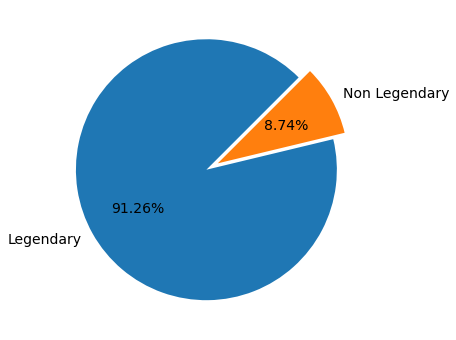

In [11]:
fig = plt.figure(figsize=(6, 6))

plt.pie(data['is_legendary'].value_counts().values,
        labels= ['Legendary', 'Non Legendary'], 
        autopct ='%0.2f%%', 
        startangle = 45,
        textprops={'fontsize': 14},
        explode=(0, 0.1));

**Muestra una visualización con cuántos Pokémons hay en cada generación en función de la variable de salida e imprime un conteo de los mismos. ¿Ves algún patrón en los datos?**

5    156
1    151
3    135
4    107
2    100
7     80
6     72
Name: generation, dtype: int64


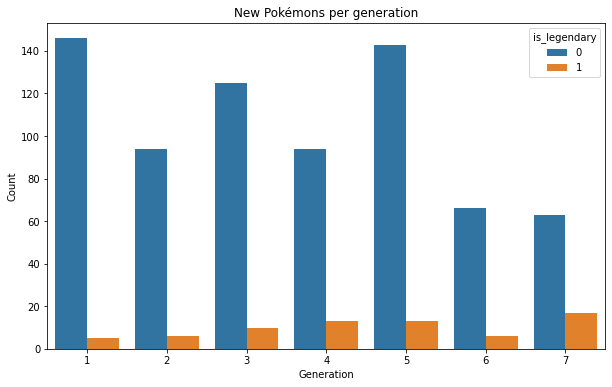

In [12]:
print(data['generation'].value_counts())
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['generation'], hue=data['is_legendary'])
ax.set_title('New Pokémons per generation')
ax.set(xlabel='Generation', ylabel='Count');

Parece que no existe una correlación entre la cantidad de Pokémon legendarios y la cantidad de Pokémon en una generación.

**Como hemos comentado, la variable `capture_rate` parece que debería ser numérica pero vemos que es de tipo `Object`, necesitamos saber qué ocurre. Muestra los posibles valores que puede tomar esta variable.**

In [13]:
data['capture_rate'].unique()

array(['45', '255', '120', '127', '90', '190', '75', '235', '150', '25',
       '170', '50', '200', '100', '180', '60', '225', '30', '35', '3',
       '65', '70', '125', '205', '155', '145', '130', '140', '15', '220',
       '160', '80', '55', '30 (Meteorite)255 (Core)'], dtype=object)

**Parece que hay algún Pokémon que tiene 2 valores para esta variable. Localiza qué Pokémon son, es decir, cómo se llaman.**

In [14]:
data[data['capture_rate'] == '30 (Meteorite)255 (Core)']['name']

773    Minior
Name: name, dtype: object

**Ahora que hemos localizado el Pokémon que está dando problemas, sustituye su `capture_rate` por el valor 30 y transforma esta columna en una de tipo numérico.**

In [15]:
# Cambiamos el capture_rate por '30' 
data.loc[data['name'] == 'Minior', 'capture_rate'] = '30'

In [16]:
# Transformamos la columna en numérica
data['capture_rate'] = pd.to_numeric(data['capture_rate'])

# Comprobamos el tipo de la columna
data['capture_rate'].dtypes

dtype('int64')

**Sabemos que los Pokémon legendarios son "poco comunes" y "poderosos", los atributos que reflejan estas cualidades pueden darnos una mejor idea de cómo podemos predecir si un Pokémon es legendario. Debido a que los Pokémon legendarios son raros, sabemos que capturarlos puede ser más difícil que atrapar Pokémons no legendarios.**

**Muestra con un boxplot cómo se distribuye la variable `capture_rate` en función de si son o no legendarios. ¿Cómo interpretas el resultado?**

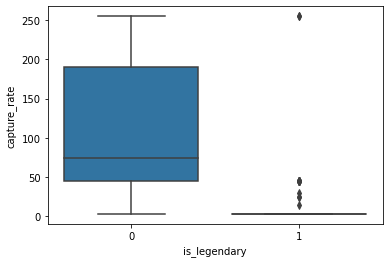

In [17]:
sns.boxplot(x='is_legendary', y='capture_rate', data=data);

Dado que cuanto mayor es la tasa de captura más fácil es capturar un Pokémon, vemos que los Pokémon legendarios son significativamente más difíciles de capturar.

**Haz lo mismo con `base_total` que muestra de forma resumida las estadísticas de fuerza, ataque, defensa y velocidad de cada Pokémon.**

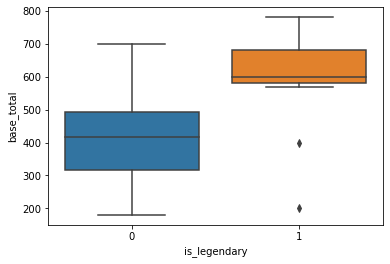

In [18]:
sns.boxplot(x='is_legendary', y='base_total', data=data);

Las estadísticas básicas parecen indicar que los Pokémon legendarios son en general más poderosos que los no legendarios.

**Crea un DataFrame con los recuentos de las clases de cada tipo.**

In [19]:
type1_value_counts = data['type1'].value_counts()
type2_value_counts = data['type2'].value_counts()
types_df = pd.concat([type1_value_counts, type2_value_counts], axis=1)
types_df

,type1,type2
water,114,17
normal,105,4
grass,78,20
bug,72,5
psychic,53,29
fire,52,13
rock,45,14
electric,39,9
poison,32,34
ground,32,34


**Usando el DataFrame anterior, muestra en un diagrama de barras apilado cuántos Pokémons hay de cada tipo. ¿Qué conclusiones sacas?**

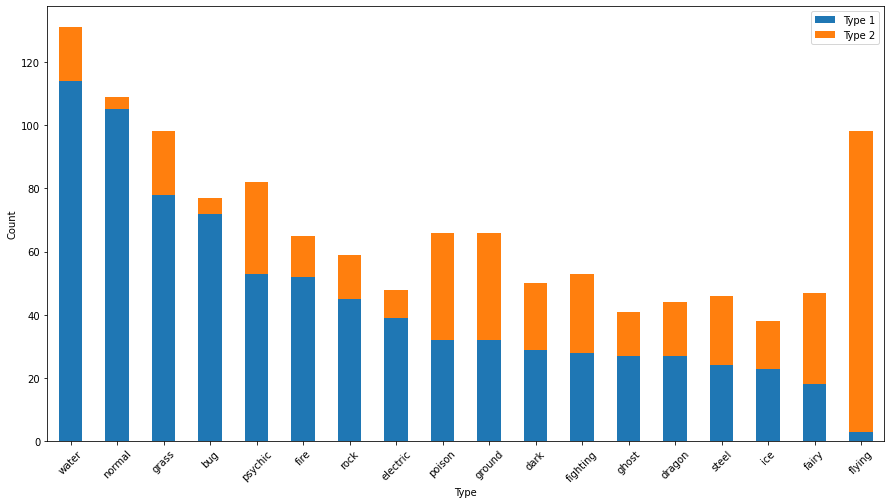

In [20]:
types_df.plot(kind='bar', stacked=True, figsize=(15, 8))

plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Type 1', 'Type 2']);

Podemos ver que todos los tipos están presentes indistintamente en los tipos primarios y secundarios de Pokémon, siendo algunos tipos más frecuentes como primarios que como secundarios y al revés.

**Reemplaza los valores nulos de la variable `type2` con el valor `N/A` y comprueba que ha funcionado.**

In [21]:
# Hacemos el reemplazo
data['type2'] = data['type2'].fillna('N/A')

# Comprobamos que ha funcionado
data['type2'].value_counts()

N/A         384
flying       95
poison       34
ground       34
psychic      29
fairy        29
fighting     25
steel        22
dark         21
grass        20
water        17
dragon       17
ice          15
rock         14
ghost        14
fire         13
electric      9
bug           5
normal        4
Name: type2, dtype: int64

**Comprueba si algún Pokémon tiene el mismo valor en `type1` y `type2`. Esto no tiene mucho sentido, por lo que si es así sustituye `type2` por `N/A` para ese Pokémon.**

In [22]:
# Comprobamos si hay alguno
any(data['type1'] == data['type2'])

True

In [23]:
# Los mostramos
data[data['type1'] == data['type2']]

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
25,"['Static', 'Lightningrod', 'Surge Surfer']",1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,...,50.0,26,95,85,110,electric,electric,NaN,1,0
49,"['Sand Veil', 'Arena Trap', 'Sand Force', 'San...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,50.0,50,35,45,90,ground,ground,NaN,1,0
50,"['Sand Veil', 'Arena Trap', 'Sand Force', 'San...",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,50.0,51,50,70,110,ground,ground,NaN,1,0
87,"['Stench', 'Sticky Hold', 'Poison Touch', 'Poi...",0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,...,50.0,88,40,50,25,poison,poison,NaN,1,0
88,"['Stench', 'Sticky Hold', 'Poison Touch', 'Poi...",0.5,1.0,1.0,1.0,0.5,0.5,1.0,1.0,1.0,...,50.0,89,65,100,50,poison,poison,NaN,1,0
491,"['Natural Cure', 'Serene Grace']",2.0,1.0,1.0,0.5,1.0,1.0,2.0,2.0,1.0,...,NaN,492,120,75,127,grass,grass,2.1,4,1
554,"['Sheer Force', 'Zen Mode']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,50.0,555,140,105,55,fire,fire,92.9,5,0


In [24]:
# Cambiamos el type2 por 'N/A' 
data.loc[data['type1'] == data['type2'], 'type2'] = 'N/A'

In [25]:
# Volvemos a comprobar si hay alguno
any(data['type1'] == data['type2'])

False

**Crea una nueva variable llamada `type` que combine ambos tipos. Si el Pokémon solo tiene `type1` dejamos eso, si tiene los dos creamos una cadena de tipo `type1_type2`.**

In [26]:
# Creamos la columna
data['type'] = data.apply(lambda x: x['type1'] if x['type2'] == 'N/A' else f"{x['type1']}_{x['type2']}", axis=1)

# Hacemos un recuento de los valores obtenidos
data['type'].value_counts()

normal             61
water              61
grass              38
psychic            35
fire               28
                   ..
dragon_electric     1
dragon_ice          1
fighting_steel      1
normal_ground       1
rock_poison         1
Name: type, Length: 161, dtype: int64

**¿Cuáles son los 5 tipos más comunes para los Pokémon legendarios?**

In [27]:
legendary_pokemon = data[data['is_legendary'] == 1]
legendary_pokemon['type'].value_counts().nlargest()

psychic           10
water              3
normal             2
dragon_psychic     2
fire_flying        2
Name: type, dtype: int64

**Usando un mapa de calor, muestra todas las combinaciones de tipos de los Pokémon. Ten en cuenta que solo debes incluir los Pokémon que tienen tanto un tipo primario como uno secundario.**

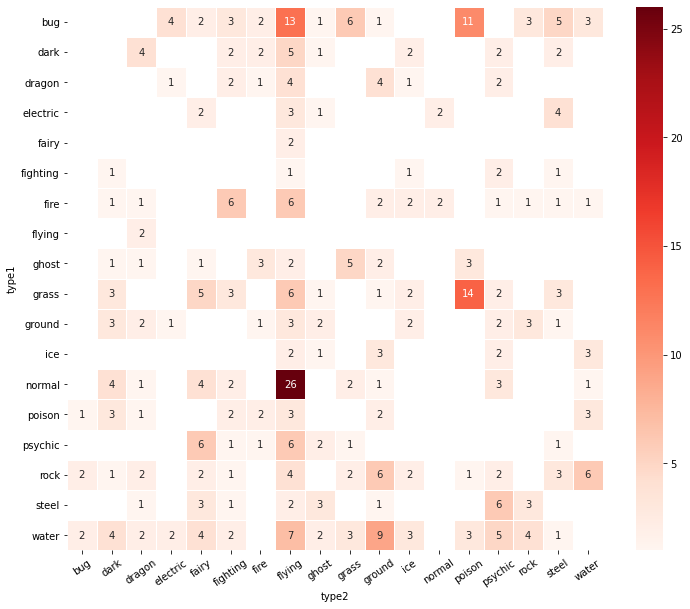

In [28]:
plt.subplots(figsize=(12, 10))

sns.heatmap(
    data[data['type2'] != 'N/A'].groupby(['type1', 'type2']).size().unstack(),
    linewidths=1,
    annot=True,
    cmap='Reds'
)

plt.xticks(rotation=35);

**Comprueba si existe alguna correlación entre los tipos de Pokémon y la variable que queremos predecir. Necesitarás convertir las variables categóricas `type1` y `type2` a numéricas usando `pd.get_dummies()`. Interpreta los resultados.**

In [29]:
## type1
# Preparamos las columnas de las que queremos analizar la correlación
type1_cols = pd.concat([pd.get_dummies(data['type1']), data['is_legendary']], axis=1)

# Calculamos la correlación
type1_cols_corr = type1_cols.corr()
type1_cols_corr[-1:]

,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water,is_legendary
is_legendary,-0.050883,0.01102,0.113667,0.032696,-0.017092,-0.058895,0.008176,0.053397,-0.033302,-0.041997,-0.017979,-0.000264,-0.080897,-0.063125,0.219961,0.001294,0.101196,-0.050138,1.0


In [30]:
## type2
# Preparamos las columnas de las que queremos analizar la correlación
type2_cols = pd.concat([pd.get_dummies(data['type2']), data['is_legendary']], axis=1)

# Calculamos la correlación
type2_cols_corr = type2_cols.corr()
type2_cols_corr[-1:]

,N/A,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water,is_legendary
is_legendary,-0.072253,-0.024526,-0.050775,0.07712,0.013376,0.082017,0.096994,0.034619,0.023215,0.026196,-0.019185,-0.040552,-0.010138,-0.021923,-0.040552,0.034686,-0.041273,0.056191,-0.014896,1.0


No parece existir una correlación entre el tipo de Pokémon y la variable de salida, por lo que en principio no usaremos estas como variables predictoras.

**Imprime un listado con todas las habilidades posibles que puede tener un Pokémon y cuéntalas. Investiga la función `eval()` para devolver el tipo `list()` a los valores de las celdas de esta variable que ahora mismo están en formato cadena de texto.**

In [31]:
# Comprobamos que el contenido de las celdas es una cadena
type(data.loc[0, 'abilities'])

str

In [32]:
# Transformamos las cadenas en listas
data['abilities'] = data.apply(lambda x: eval(x['abilities']), axis=1)

In [33]:
# Comprobamos que el contenido de las celdas ahora es una lista
type(data.loc[0, 'abilities'])

list

In [34]:
abilities = set(x for lst in data['abilities'].values.tolist() for x in lst)
print(abilities)
print(f'\nExisten {len(abilities)} habilidades diferentes que un Pokémon puede tener.')

{'Magic Bounce', 'Storm Drain', 'Swarm', 'Aroma Veil', 'Mold Breaker', 'Limber', 'Gooey', 'Psychic Surge', 'Solar Power', 'Poison Touch', 'Scrappy', 'Flower Gift', 'Klutz', 'Imposter', 'Pressure', 'Grass Pelt', 'Dancer', 'Iron Barbs', 'Vital Spirit', 'Lightningrod', 'Filter', 'Unaware', 'Aura Break', 'Hyper Cutter', 'Torrent', 'Cursed Body', 'Multitype', 'Infiltrator', 'Sand Veil', 'Drizzle', 'Rough Skin', 'Friend Guard', 'Solid Rock', 'Keen Eye', 'Static', 'Air Lock', 'Prism Armor', 'Gale Wings', 'Fur Coat', 'Stamina', 'Disguise', 'Forecast', 'Liquid Voice', 'Slush Rush', 'Cheek Pouch', 'Illusion', 'Drought', 'Multiscale', 'Electric Surge', 'Normalize', 'Oblivious', 'Justified', 'Own Tempo', 'Guts', 'Marvel Scale', 'Super Luck', 'Pickpocket', 'RKS System', 'Full Metal Body', 'Anger Point', 'Dazzling', 'Sap Sipper', 'Snow Warning', 'Minus', 'Refrigerate', 'Emergency Exit', 'Forewarn', 'Turboblaze', 'Stench', 'Toxic Boost', 'Victory Star', 'Technician', 'Plus', 'Corrosion', 'Motor Drive

**Crea otra característica que sea más informativa a partir de `abilities` con el número de habilidades de cada Pokémon y nómbrala `n_abilities`.**

In [35]:
# Creamos la nueva variable con el número de habilidades
data['n_abilities'] = data.apply(lambda x: len(x['abilities']), axis=1)

In [36]:
# Hacemos un recuento para comprobar que ha funcionado
data['n_abilities'].value_counts()

3    427
2    245
1    109
6     13
4      7
Name: n_abilities, dtype: int64

**Muestra un gráfico que relacione el número de habilidades que un Pokémon puede tener con la variable de salida y explica si encuentras algún patrón.**

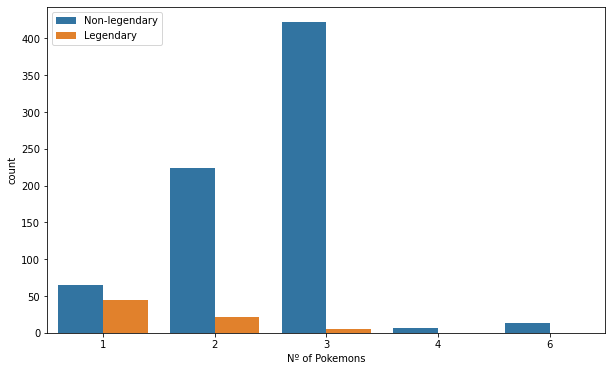

In [37]:
plt.figure(figsize=(10, 6))

sns.countplot(data=data, x='n_abilities', hue='is_legendary')
plt.xlabel('Nº of abilities')
plt.xlabel('Nº of Pokemons')
plt.legend(['Non-legendary', 'Legendary']);

Parece que los Pokémon legendarios no tienen más de 3 habilidades. 3 es el número más común de habilidades para los Pokémon no legendarios, mientras que la mayoría de los Pokémon legendarios solo tienen 1 habilidad.

**Vamos a analizar usando una serie de boxplots cómo se distribuyen las características `['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'hp', 'sp_attack', 'sp_defense', 'speed']` en función de si los Pokémon son o no legendarios.**

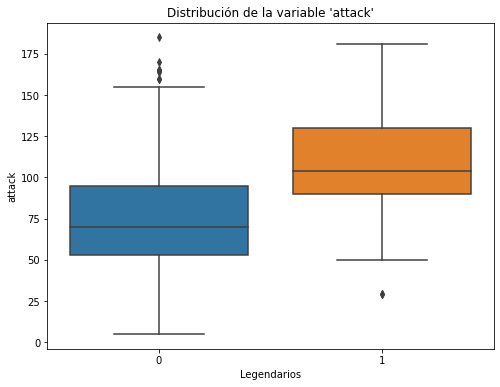

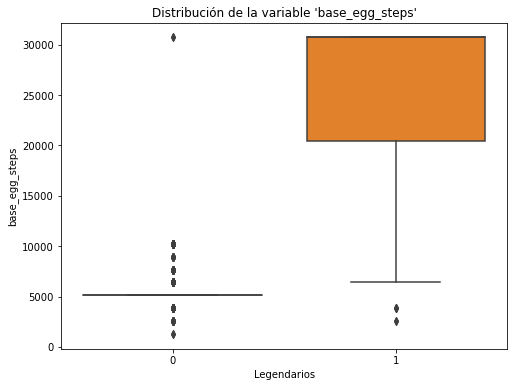

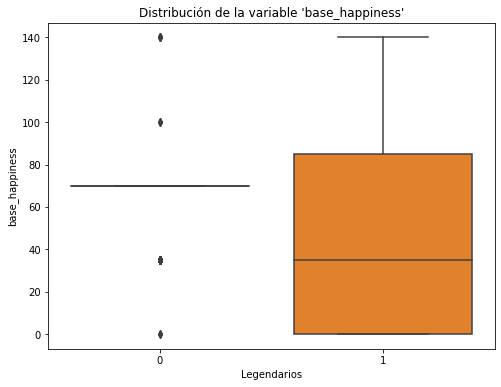

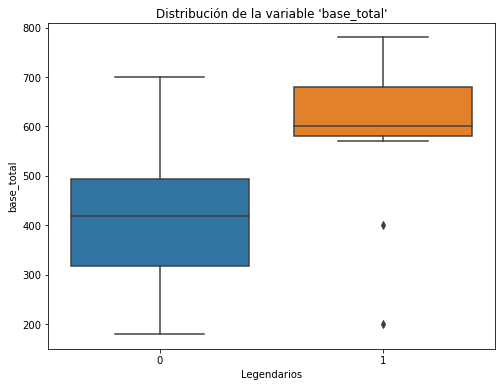

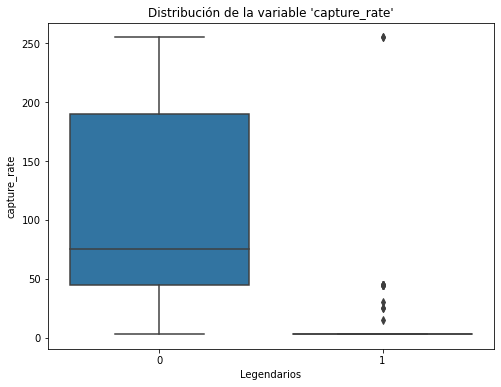

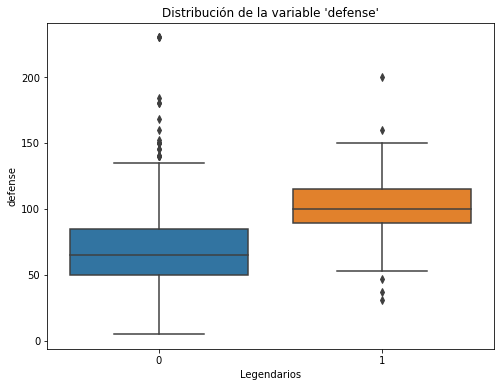

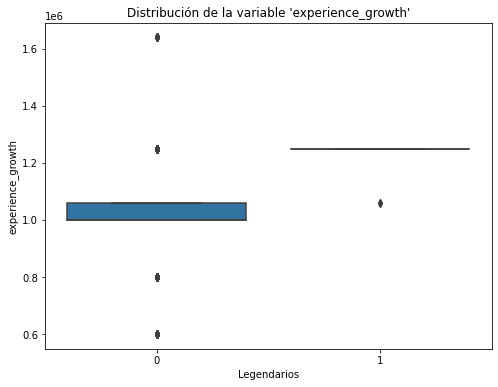

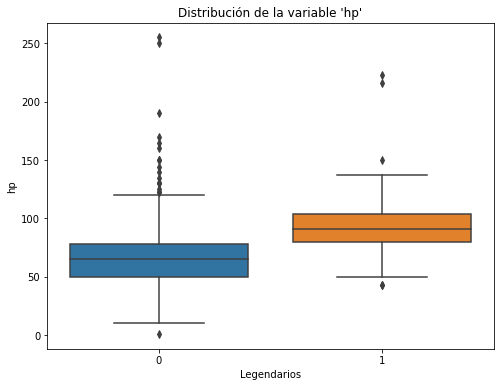

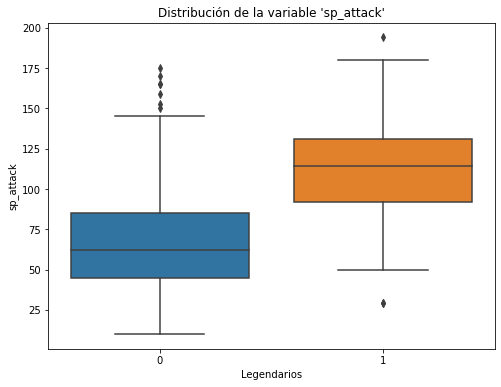

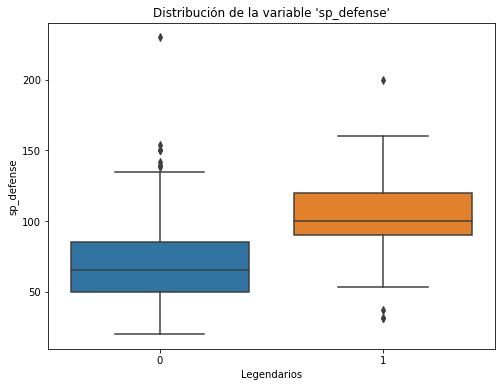

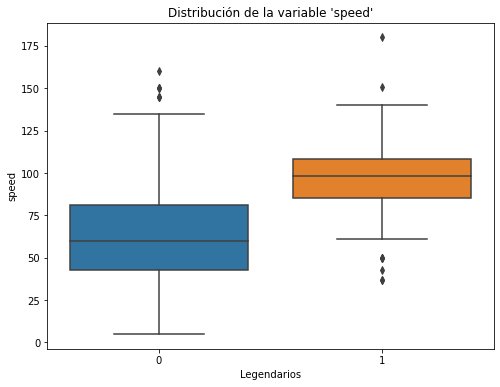

In [38]:
columns_to_plot = ['attack', 'base_egg_steps', 'base_happiness', 'base_total',
                   'capture_rate', 'defense', 'experience_growth', 'hp',
                   'sp_attack', 'sp_defense', 'speed']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_legendary', y=column, data=data)
    plt.xlabel('Legendarios')
    plt.title(f"Distribución de la variable '{column}'");

Parece que existen claras diferencias entre los Pokémon legendarios y los que no lo son, por lo que estas variables seguramente van a ser de interés a la hora de entrenar nuestro modelo.

**Rellena los valores nulos de la variable `percentage_male` con un -1, que se va a corresponder con aquellos Pokémon que no tienen género.**

In [39]:
data['percentage_male'] = data['percentage_male'].fillna(-1)

**Imputa los valores ausentes de peso y altura con el peso y la altura medios para el `type1` de ese Pokémon. Comprueba que ya no tienes valores ausentes en esas columnas.**

In [40]:
# Imputamos la altura
data['height_m'] = data['height_m'].fillna(data.groupby('type1')['height_m'].transform('mean'))

In [41]:
# Imputamos el peso
data['weight_kg'] = data['weight_kg'].fillna(data.groupby('type1')['weight_kg'].transform('mean'))

In [42]:
# Calculamos el número de valores ausentes
data[['height_m', 'weight_kg']].isnull().sum()

height_m     0
weight_kg    0
dtype: int64

**Muestra en un gráfico cómo se distribuyen el peso y la altura de los Pokémon.**

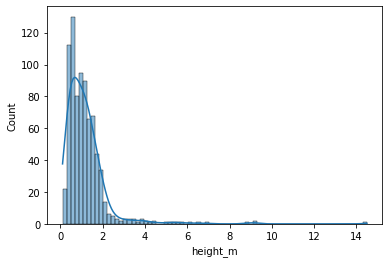

In [43]:
# Distribución altura
sns.histplot(data['height_m'], kde=True);

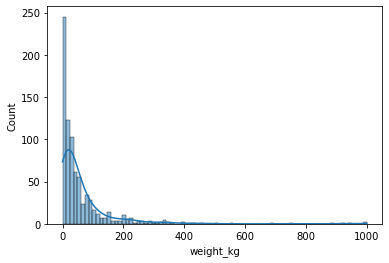

In [44]:
# Distribución peso
sns.histplot(data['weight_kg'], kde=True);

**Crea un scatterplot usando la altura y peso de los Pokémon en el que se diferencie entre legendarios y no legendarios. Anota en el gráfico el nombre de los 5 Pokémon más pesados y los 5 más altos. ¿Qué deduces del gráfico?**

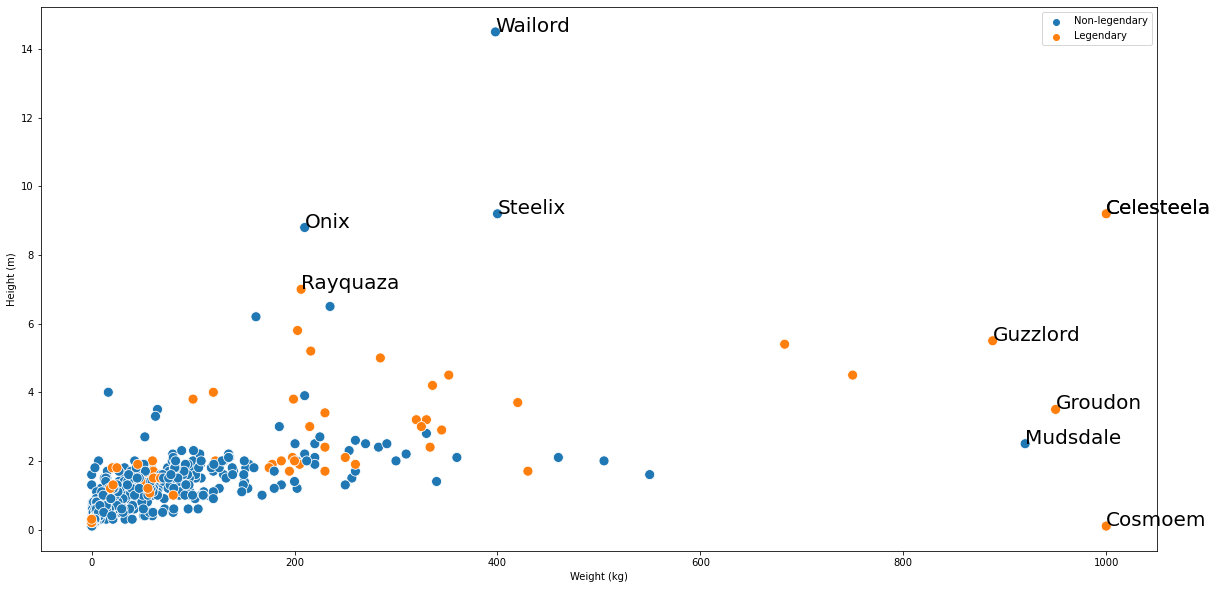

In [45]:
# Dibujamos el scatterplot
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x='weight_kg',
                     y='height_m',
                     hue ='is_legendary',
                     data=data,
                     s=100)
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Height (m)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Non-legendary', 'Legendary']);

filter_pokemon = pd.concat([data['weight_kg'].nlargest(5), data['height_m'].nlargest(5)])

# Anotamos el nombre de los Pokémon con mayor BMI
for index, row in filter_pokemon.iteritems():
    plt.annotate(data.loc[index, 'name'],
                 xy=(data.loc[index, 'weight_kg'], data.loc[index, 'height_m']),
                 fontsize=20)

Dos de los cinco Pokémon más altos son legendarios, mientras que cuatro de los cinco Pokémon más pesados son legendarios.

**Analiza usando un mapa de calor la correlación existente entre las variables `against_?` del conjunto de datos y la variable de salida. ¿Qué conclusiones sacas?**

In [46]:
# Nos quedamos con las variables que queremos analizar
columns_to_plot = ['against_bug', 'against_dark', 'against_dragon',
                   'against_electric', 'against_fairy', 'against_fight',
                   'against_fire', 'against_flying', 'against_ghost',
                   'against_grass', 'against_ground', 'against_ice',
                   'against_normal', 'against_poison', 'against_psychic',
                   'against_rock', 'against_steel', 'against_water', 'is_legendary']

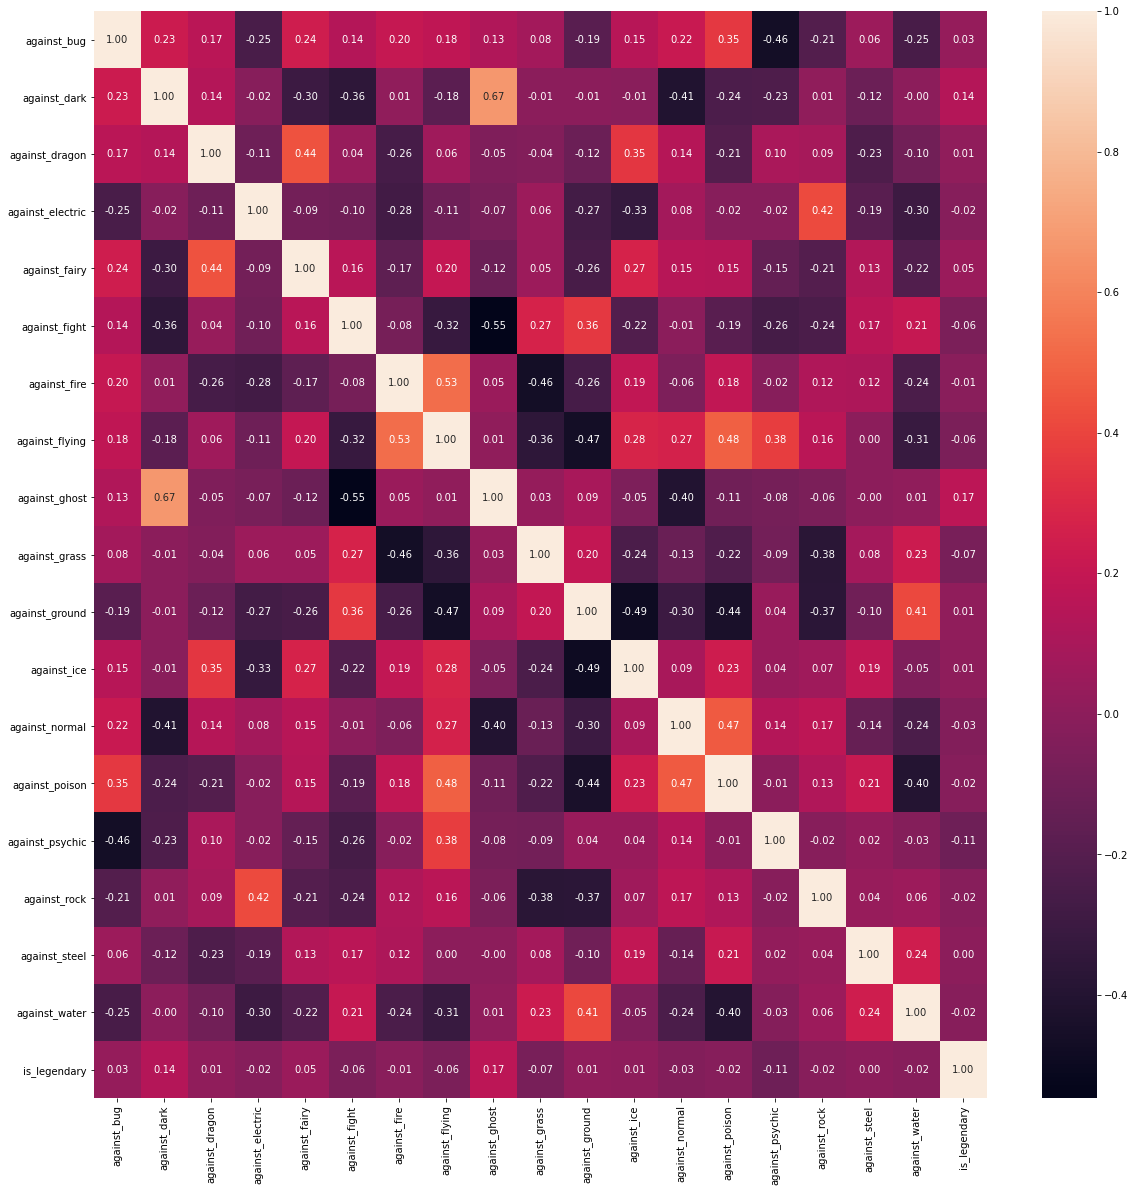

In [47]:
# Crea el mapa de calor con los índices de correlación
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data[columns_to_plot].corr(), annot=True, fmt='.2f');

No parece existir apenas correlación entre este tipo de variables y la de salida.

**En base en a lo analizado hasta ahora, quédate con las columnas que consideres más informativas a efectos predictivos.**

In [48]:
data = data[['attack', 'base_egg_steps', 'base_happiness', 'base_total',
             'capture_rate', 'defense', 'experience_growth', 'height_m',
             'hp', 'percentage_male', 'sp_attack', 'sp_defense', 'speed',
             'weight_kg', 'n_abilities', 'is_legendary']]

**Crea un mapa de calor que muestre cómo se correlacionan las características seleccionadas y la variable a predecir, ¿qué observas?**

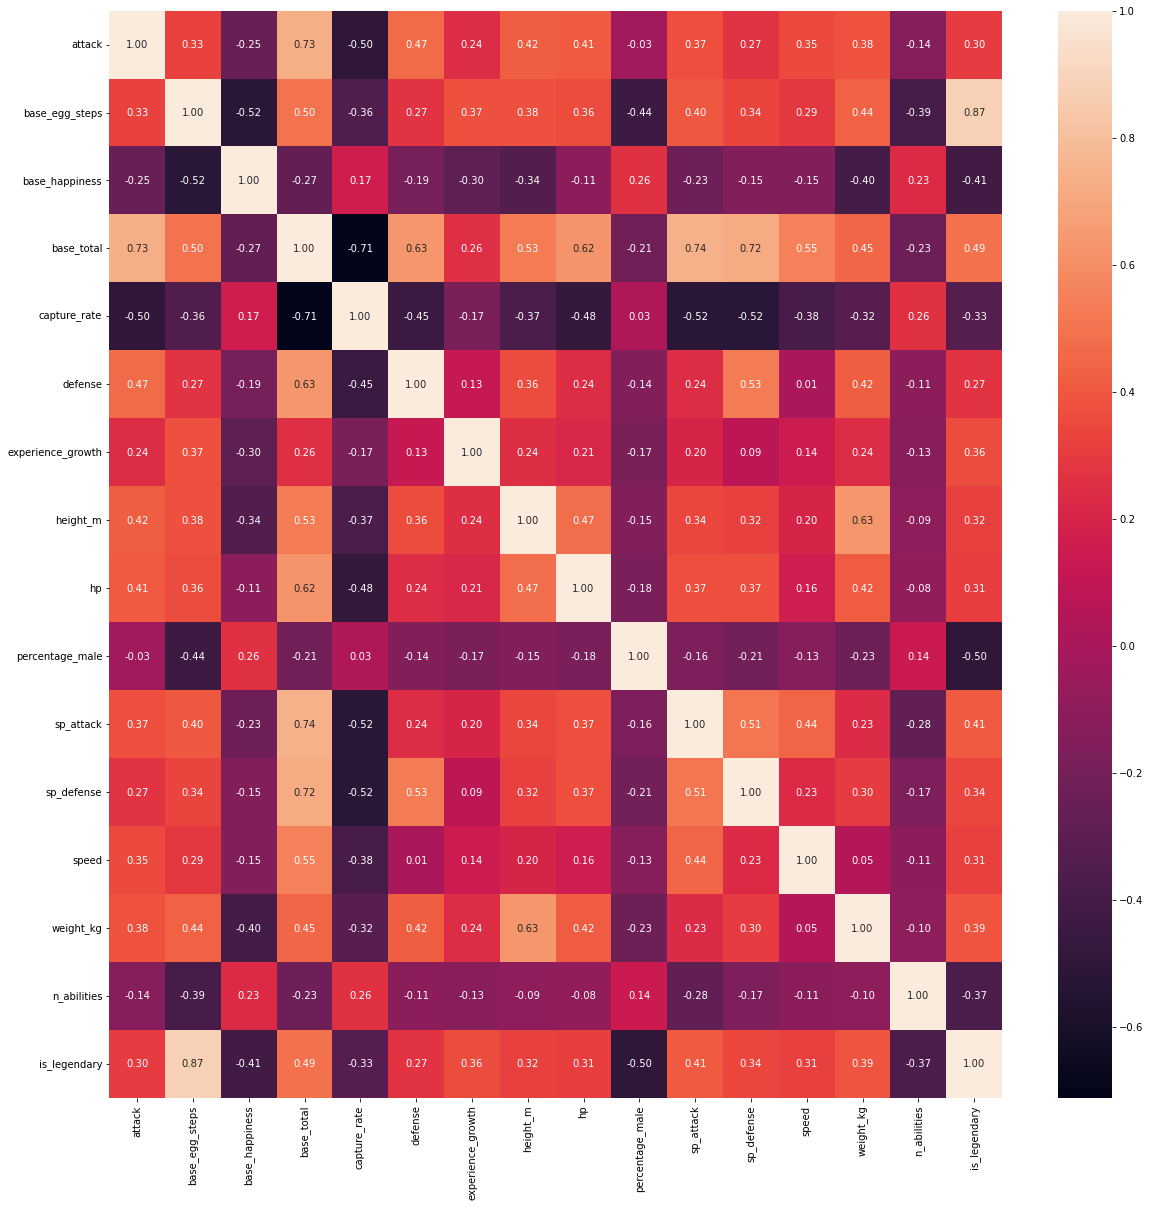

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.yticks(va='center');

`base_egg_steps` tiene una alta correlación positiva con ser Pokémon legendario. `base_happiness`, `percent_male`, `capture_rate` y `n_abilities` tienen una correlación negativa.

`base_total` tiene mayor correlación con la variable de salida por sí sola que cualquiera de las características que aglutina de manera individual por lo que deberíamos quedarnos solo con ella y eliminar el resto.

In [50]:
data = data[['base_egg_steps', 'base_happiness', 'base_total',
             'capture_rate', 'experience_growth', 'height_m',
             'percentage_male', 'weight_kg', 'n_abilities',
             'is_legendary']]

## División conjuntos de entrenamiento y prueba

**Separa las variables de entrada de la variable de salida y asígnalas a dos variables llamadas `X` e `y` respectivamente.**

In [51]:
X = data.drop('is_legendary', axis=1)
y = data['is_legendary']

**Divide el dataset en los conjuntos de entrenamiento y prueba usando la función `train_test_split()` de la librería Scikit-Learn en una proporción de 70/30. Usa un `random_state=0` y estratifica en base a `y`.**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)

## Entrenar y evaluar clasificadores

**Entrena y evalúa un clasificador $k$-NN. Selecciona para ello el mejor valor de $k$.**

In [53]:
# Escala los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [54]:
# Recrea el dataset de entrenamiento con las columnas estandarizadas
X_train = pd.DataFrame(X_train_scaled, columns=data.columns[:-1])
X_train.head()

,base_egg_steps,base_happiness,base_total,capture_rate,experience_growth,height_m,percentage_male,weight_kg,n_abilities
0,0.090909,0.50,0.375000,0.781746,0.384615,0.020833,0.504950,0.004101,0.2
1,0.136364,0.50,0.275000,0.087302,0.625000,0.062500,0.504950,0.064913,0.4
2,0.090909,0.50,0.268333,0.781746,0.384615,0.020833,0.504950,0.003401,0.2
3,0.227273,0.25,0.575000,0.166667,0.384615,0.048611,0.882178,0.025805,0.2
4,0.272727,0.25,0.866667,0.000000,0.625000,0.104167,0.000000,0.550010,0.2


In [55]:
# Escala el conjunto de prueba
X_test_scaled = scaler.transform(X_test)

In [56]:
# Recrea el dataset de prueba con las columnas estandarizadas
X_test = pd.DataFrame(X_test_scaled, columns=data.columns[:-1])
X_test.head()

,base_egg_steps,base_happiness,base_total,capture_rate,experience_growth,height_m,percentage_male,weight_kg,n_abilities
0,0.090909,0.5,0.233333,1.000000,0.442173,0.027778,0.504950,0.005301,0.2
1,0.090909,0.5,0.575000,0.166667,0.442173,0.118056,0.882178,0.100420,0.2
2,0.090909,0.5,0.463333,0.345238,1.000000,0.180556,0.504950,0.052410,0.2
3,0.090909,0.5,0.116667,0.742063,0.384615,0.041667,0.504950,0.034907,0.4
4,0.045455,0.5,0.466667,0.345238,1.000000,0.076389,0.504950,0.039108,0.4


In [57]:
# Usa GridSearchCV para seleccionar k
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid={'n_neighbors': np.arange(1, 20, 2)},  # Nº impares entre 1 y 20
                        cv=5)

In [58]:
# Entrena el clasificador
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])})

In [59]:
# Muestra el mejor k
knn_grid.best_params_

{'n_neighbors': 3}

In [60]:
# Imprime la exactitud en los set de entrenamiento y prueba
print(f'Accuracy of k-NN on training set: {knn_grid.score(X_train, y_train):.2f}')
print(f'Accuracy of k-NN on test set: {knn_grid.score(X_test, y_test):.2f}')

Accuracy of k-NN on training set: 1.00
Accuracy of k-NN on test set: 0.99


In [61]:
# Realiza las predicciones
y_pred_knn = knn_grid.predict(X_test)

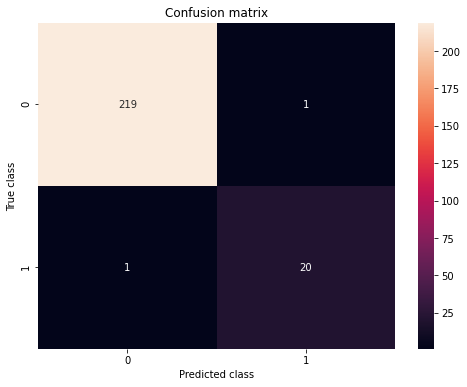

In [62]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

In [63]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       220
           1       0.95      0.95      0.95        21

    accuracy                           0.99       241
   macro avg       0.97      0.97      0.97       241
weighted avg       0.99      0.99      0.99       241



**Entrena y evalúa un clasificador de regresión logística. Ajusta sus hiperparámetros.**

In [64]:
# Usa GridSearchCV para seleccionar los hiperparámetros
# Te proponemos estos pero prueba los que quieras
param_dict = {'solver': ['lbfgs', 'liblinear'],
              'penalty': ['l2'],
              'C': [100, 10, 1.0, 0.1, 0.01]}

lr_grid = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=param_dict,
                       cv=5)

In [65]:
# Entrena el clasificador
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']})

In [66]:
# Muestra los mejores parámetros
lr_grid.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

In [67]:
# Imprime la exactitud en los set de entrenamiento y prueba
print(f'Accuracy of LR on training set: {lr_grid.score(X_train, y_train):.2f}')
print(f'Accuracy of LR on test set: {lr_grid.score(X_test, y_test):.2f}')

Accuracy of LR on training set: 0.99
Accuracy of LR on test set: 0.99


In [68]:
# Realiza las predicciones
y_pred_lr = lr_grid.predict(X_test)

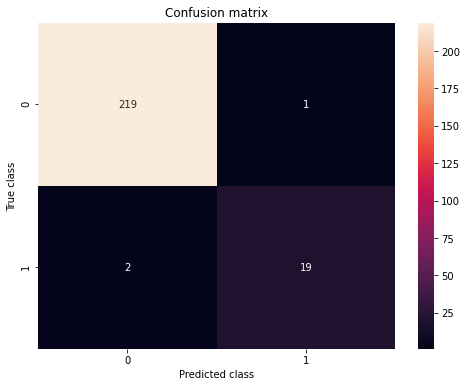

In [69]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

In [70]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       220
           1       0.95      0.90      0.93        21

    accuracy                           0.99       241
   macro avg       0.97      0.95      0.96       241
weighted avg       0.99      0.99      0.99       241



**Entrena y evalúa un clasificador de árbol de decisión. Ajusta sus hiperparámetros.**

In [71]:
# Usa GridSearchCV para seleccionar los hiperparámetros
# Te proponemos estos pero prueba los que quieras
param_dict = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None], 
    'class_weight': ['balanced', None]
}

dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=10),
                       param_grid=param_dict,
                       cv=5)

In [72]:
# Entrena el clasificador
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, None]})

In [73]:
# Muestra los mejores parámetros
dt_grid.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3}

In [74]:
# Imprime la exactitud en los set de entrenamiento y prueba
print(f'Accuracy of DT on training set: {dt_grid.score(X_train, y_train):.2f}')
print(f'Accuracy of DT on test set: {dt_grid.score(X_test, y_test):.2f}')

Accuracy of DT on training set: 1.00
Accuracy of DT on test set: 1.00


In [75]:
# Realiza las predicciones
y_pred_dt = dt_grid.predict(X_test)

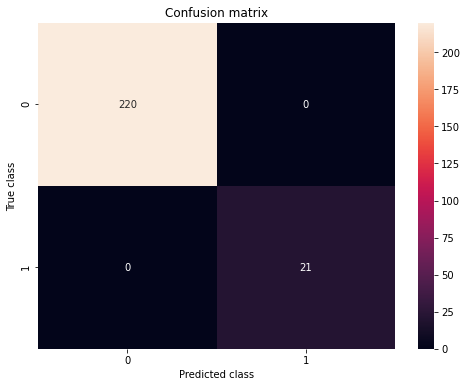

In [76]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_dt, labels=[0, 1])
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

In [77]:
# Imprime el informe de clasificación
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       220
           1       1.00      1.00      1.00        21

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



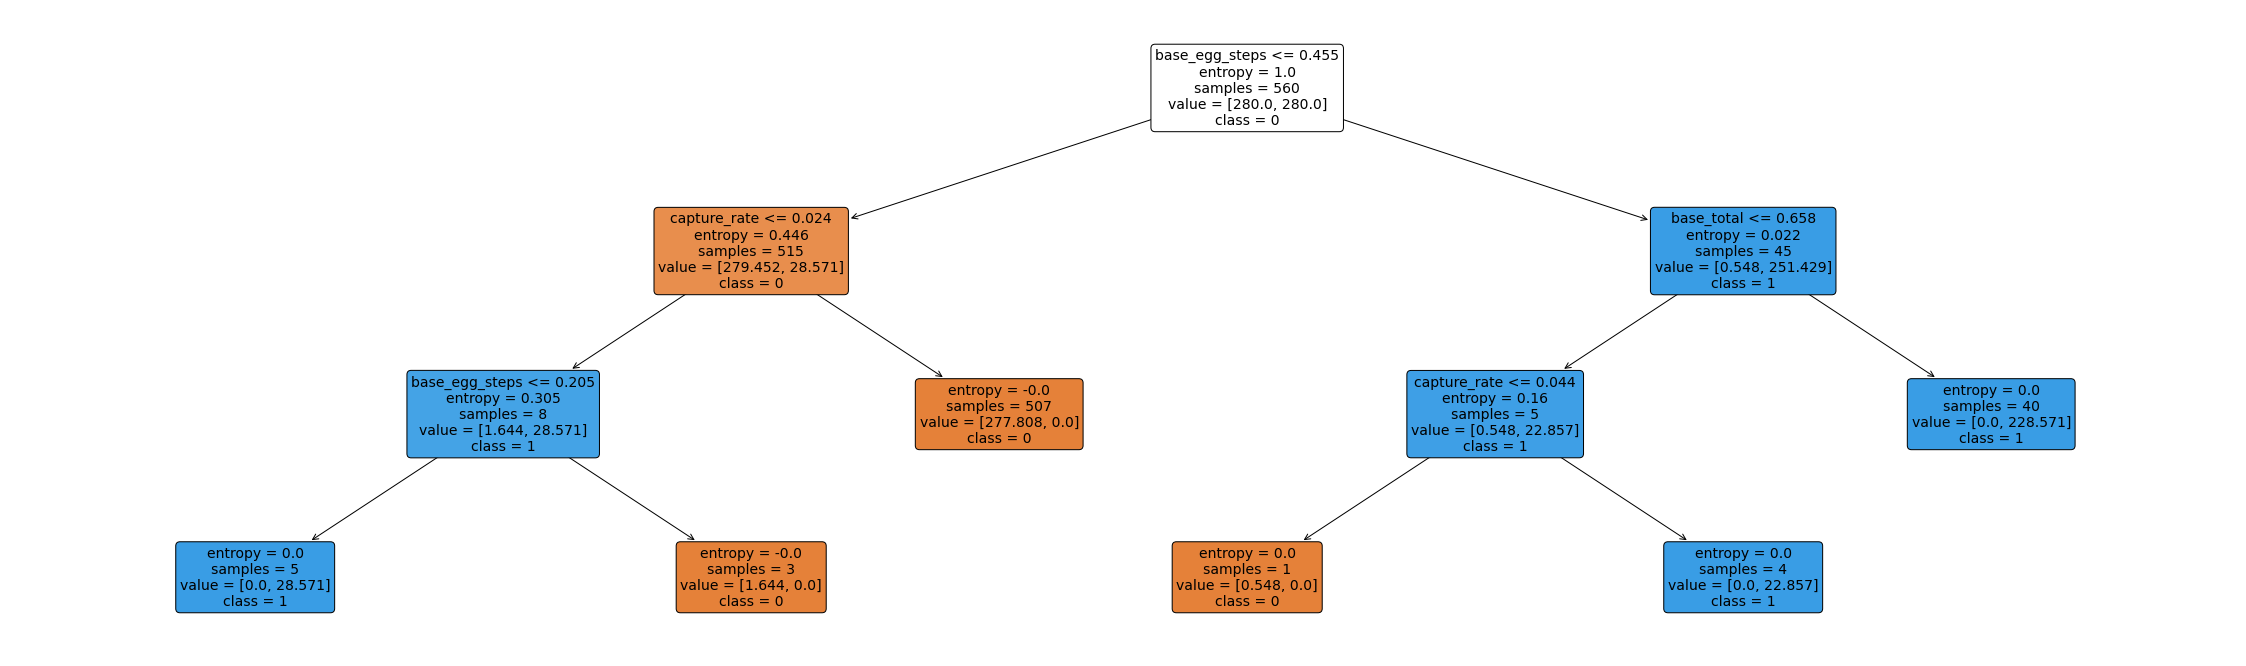

In [78]:
# Muestra el árbol de decisión
plt.figure(figsize=(40, 4 * dt_grid.best_estimator_.get_depth()))
dt = plot_tree(dt_grid.best_estimator_,
               feature_names=X.columns,
               class_names= ['0', '1'],
               filled=True,
               rounded=True,
               fontsize=14)

# Guarda la imagen
plt.savefig('pokemon_tree.png')

In [79]:
# Crea un informe de texto que muestra las reglas del árbol de decisión
print(export_text(dt_grid.best_estimator_, feature_names=list(X.columns)))

|--- base_egg_steps <= 0.45
|   |--- capture_rate <= 0.02
|   |   |--- base_egg_steps <= 0.20
|   |   |   |--- class: 1
|   |   |--- base_egg_steps >  0.20
|   |   |   |--- class: 0
|   |--- capture_rate >  0.02
|   |   |--- class: 0
|--- base_egg_steps >  0.45
|   |--- base_total <= 0.66
|   |   |--- capture_rate <= 0.04
|   |   |   |--- class: 0
|   |   |--- capture_rate >  0.04
|   |   |   |--- class: 1
|   |--- base_total >  0.66
|   |   |--- class: 1



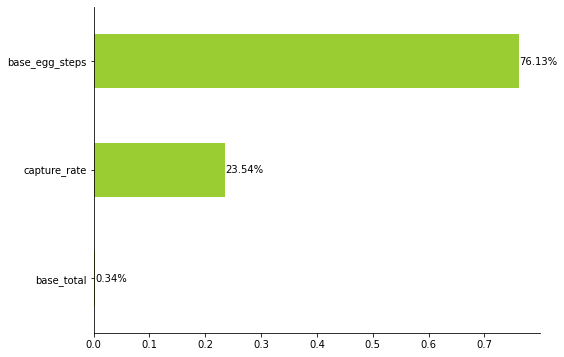

In [80]:
# Muestra la importancia de las características
# pero solo las que tienen importancia > 0
feat_importances = pd.DataFrame(dt_grid.best_estimator_.feature_importances_,
                                index=X.columns,
                                columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)

ax = feat_importances[feat_importances['Importance'] > 0].plot(kind='barh',
                                                               figsize=(8, 6),
                                                               color='yellowgreen')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()

for p in ax.patches:
    width = p.get_width()
    plt.text(width,
             p.get_y() + 0.5 * p.get_height(),
             '{:1.2f}%'.format(width * 100),
             ha='left',
             va='center')

## Comparar desempeño de los clasificadores

**Muestra la curva ROC para cada unos de los clasificadores en una misma gráfica e incluye en la visualización el AUC. Interpreta los resultados.**

In [81]:
# Calcula las probabilidades de predicción de cada modelo
pred_prob_knn = knn_grid.predict_proba(X_test)
pred_prob_lr = lr_grid.predict_proba(X_test)
pred_prob_dt = dt_grid.predict_proba(X_test)

In [82]:
# Calcula la curva ROC para los modelos
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_knn[:, 1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_lr[:, 1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_dt[:, 1], pos_label=1)

# Calcula la curva ROC para un clasificador aleatorio
# que sirva de referencia, donde tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [83]:
# Calcula la puntuación AUC para los modelos
auc_score_knn = roc_auc_score(y_test, pred_prob_knn[:, 1])
auc_score_lr = roc_auc_score(y_test, pred_prob_lr[:, 1])
auc_score_dt = roc_auc_score(y_test, pred_prob_dt[:, 1])

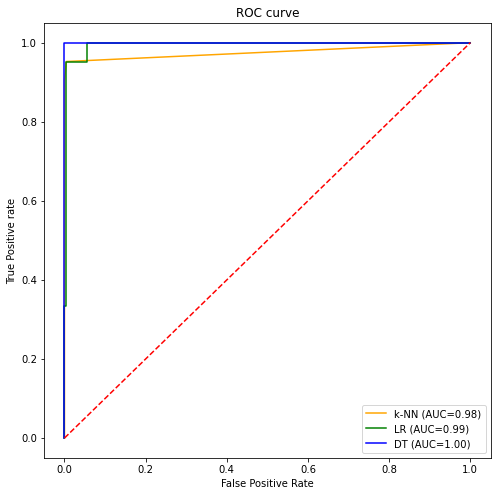

In [84]:
# Visualiza la curva ROC para los 4 modelos
plt.figure(figsize=[8, 8])

plt.plot(fpr1, tpr1, linestyle='-', color='orange',
         label=f'k-NN (AUC={auc_score_knn:.2f})')
plt.plot(fpr2, tpr2, linestyle='-', color='green',
         label=f'LR (AUC={auc_score_lr:.2f})')
plt.plot(fpr3, tpr3, linestyle='-', color='blue',
         label=f'DT (AUC={auc_score_dt:.2f})')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best');

Como vemos, aunque todos los clasificadores que hemos entrenado tienen un desempeño bastante bueno, el clasificador basado en el árbol de decisión ha conseguido clasificar perfectamente entre Pokémons legendarios y no legendarios en base a solo 3 características.

En lo otros dos modelos, si bien la sensibilidad que es la métrica que más nos interesa era alta, el árbol de decisión ha conseguido mejorarla.